<img style="float: right; width: 150px;" src="data/firrm.jpg">

## <span style="color:#4375c7">Inflation and Bitcoin: A descriptive time-series analysis</span>
***
*This is the main JupyterHub File including all the relevant code of the above mentioned Paper. It is segmented by the different statistical test executed. This file uses external content of the "T5YIFR.csv".*
***

## Structure
This file is strucured as follows:

### Content:
1. **[Library Import](#101)**
2. **[Data](#fit)**
3. **[Descriptive Summary Statistics](#summary)**
4. **[Augmented Dickey-Fuller Test](#ADF)**
5. **[VAR-Model, AIC and Likelihood Ratio Test](#VAR)**
6. **[Granger Causality Test](#GRANGER)**
7. **[Impulse Response Function](#IRF)**



***

## 1. Library Import <a id='101'></a>

First, relevant libraries are installed and imported. Besides the standrard libraries which were treated in the lecture (pandas and numpy for data modelling, matplotlib for visualization and statsmodels for econometric analysis), **cryptocmd library** enables an import of cryptocurrency historical price data from https://coinmarketcap.com.
***
cryptocmd library - https://github.com/guptarohit/cryptoCMDhttps://github.com/guptarohit/cryptoCMD 

In [1]:
pip install cryptocmd   

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 KB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install git+git://github.com/guptarohit/cryptoCMD.git

  Cloning git://github.com/guptarohit/cryptoCMD.git to /tmp/pip-req-build-1adaxi9m
  Running command git clone --filter=blob:none --quiet git://github.com/guptarohit/cryptoCMD.git /tmp/pip-req-build-1adaxi9m
  Resolved git://github.com/guptarohit/cryptoCMD.git to commit 86ed81feed1ba533f4a526f885e021efbc53956d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [35]:
from cryptocmd import CmcScraper                                       # Import Coinmarketbase scraper 
import pandas as pd                                                    
import numpy as np      
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR                                   # Import VAR Class                  
from statsmodels.tsa.base.datetools import dates_from_str 
from statsmodels.tsa.stattools import adfuller                        # Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import grangercausalitytests           # Import Granger-Causality Test
from tabulate import tabulate
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression

## 2. Import and Adjustment of Data  <a id='fit'></a>

After importing libraries the next step is to scrape daily Bitcoin prices (BTC) and import the 5-Year Forward Inflation Expectation Rate (T5YIFR). Both Time-Series are cleaned of errors and missing values and are merged into one single dataframe. Finally, a dataframe of daily percent change is created.

In [15]:
scraper = CmcScraper("BTC", "01-01-2019", "31-12-2020")             # Scraping relevant Bitcoin time-series
headers, data = scraper.get_data()                                  
scraper.export("csv")                                               # Create csv-file of relevant timeframe
df = scraper.get_dataframe()                                        # Create dataframe from time-series
df= df.set_index('Date')                                            # Create Datetime index of dataframe

In [17]:
BTC_close = df[['Close']]                                          # Create dataframe with only relevant prices
BTC_close = BTC_close.dropna()                                     # Filter for missing values and errors
BTC_close = BTC_close.iloc[::-1]                                   # inverting time-series to begin from 01-01-2019
BTC_close = BTC_close.rename(columns={"Close": "BTC"}) 
BTC_close

,BTC
Date,
2019-01-01,3843.519967
2019-01-02,3943.409337
2019-01-03,3836.741319
2019-01-04,3857.717619
2019-01-05,3845.194460
...,...
2020-12-27,26272.294567
2020-12-28,27084.807886
2020-12-29,27362.436557


In [19]:
IFR = pd.read_csv('T5YIFR.csv', index_col = 0)            # Import 5-year forward Inflation Rate csv-file as dataframe
IFR = IFR.dropna()                                        # Filter for missing values and errors
IFR = IFR[IFR.T5YIFR != '.']                              # Filter for cells only containing '.'    
IFR =IFR.iloc[:].astype(float)                            # Convert all values to datatype 'float'
IFR.index = pd.to_datetime(IFR.index)                     # Convert index values to datatype 'Datetime'                                                     
IFR   

,T5YIFR
DATE,
2019-01-02,1.91
2019-01-03,1.87
2019-01-04,1.94
2019-01-07,1.95
2019-01-08,1.98
...,...
2020-12-24,2.02
2020-12-28,2.02
2020-12-29,2.02


In [20]:
abs_values = IFR.join(BTC_close)                             # Merge both Time-Series into one dataframe
abs_values

,T5YIFR,BTC
DATE,,
2019-01-02,1.91,3943.409337
2019-01-03,1.87,3836.741319
2019-01-04,1.94,3857.717619
2019-01-07,1.95,4025.248287
2019-01-08,1.98,4030.847999
...,...,...
2020-12-24,2.02,23735.949728
2020-12-28,2.02,27084.807886
2020-12-29,2.02,27362.436557


In [21]:
pct_values = abs_values.pct_change()                                # Deduct daily percent change dataframe from absolute dataframe
pct_values = pct_values.dropna()                                    # Filter for missing values and errors

## 3. Descriptive Summary Statistics  <a id='summary'></a>

Both dataframes, absolute and percentual, are analyzed. The amount of datapoints, mean, standard deviation, minimum value, 50% percentile and maximum value are then depicted in a final table.

In [27]:
summary_abs = abs_values.describe().T                                                    # Create and transpose descriptive summary statistics for absolute dataframe
summary_abs = summary_abs.drop(['25%'],axis=1)                                           # Remove 25% percentile from dataframe
summary_abs = summary_abs.drop(['75%'],axis=1)                                           # Remove 75% percentile from dataframe

In [28]:
summary_pct = pct_values.describe().T                                                    # Create and transpose descriptive summary statistics for relative dataframe
summary_pct = summary_pct.rename(index={"T5YIFR": "%T5YIFR", "Close": "%BTC"})           # Rename rows
summary_pct = summary_pct.drop(['25%'],axis=1)                                           # Remove 25% percentile from dataframe 
summary_pct = summary_pct.drop(['75%'],axis=1)                                           # Remove 75% percentile from dataframe

In [29]:
complete_summary = pd.concat([summary_abs,summary_pct])                                  # Merge both summaries 
complete_summary.round(5)                                                                #Round values

,count,mean,std,min,50%,max
T5YIFR,501.0,1.77056,0.19865,0.86000,1.80000,2.10000
BTC,501.0,9265.59299,4032.44416,3399.47164,9181.01795,29001.71982
%T5YIFR,500.0,0.00056,0.03026,-0.21818,0.00000,0.38372
BTC,500.0,0.00503,0.04483,-0.37170,0.00144,0.22513


## 4. Augmented Dickey-Fuller Test  <a id='ADF'></a>

In order to test for stationarity of the time-series the augmented dickey fuller test is applied. A loop is applied to test the ADF test with 1,3 and 5 lags, printing out respective p-values and adf-statistics.

In [30]:
#This section assigns variables to tau statistics and p-values of ADF-Test with 1,3 and 5 lags for both time series

for i in [1,3,5]:
    globals()['BTC_p_AR%s' % i] = str(adfuller(pct_values["BTC"], maxlag = i, regression = "ct", autolag = None, regresults = True)[1])
    globals()['BTC_Tau_AR%s' % i] = str(adfuller(pct_values["BTC"], maxlag = i, regression = "ct", autolag = None, regresults = True)[0].round(4))
 
for i in [1,3,5]:
    globals()['T5_p_AR%s' % i] = str(adfuller(pct_values["T5YIFR"], maxlag = i, regression = "ct", autolag = None, regresults = True)[1])
    globals()['T5_Tau_AR%s' % i] = str(adfuller(pct_values["T5YIFR"], maxlag = i, regression = "ct", autolag = None, regresults = True)[0].round(4))


In [31]:
#This section creates a complete output table for the ADF-Test


col_names = ["Statistics","%ΔT5YIFR", "%ΔBitcoin"] 

for i in [1,3,5]:
    globals()['table_AR%s' % i] = PrettyTable()
    globals()['table_AR%s' % i].title = f"AR({i})"
    globals()['table_AR%s' % i].field_names = col_names

table_AR1.add_row(['Tau Statistic',T5_Tau_AR1,BTC_Tau_AR1])
table_AR1.add_row(['p value',T5_p_AR1,BTC_p_AR1])

table_AR3.add_row(['Tau Statistic',T5_Tau_AR3,BTC_Tau_AR3])
table_AR3.add_row(['p value',T5_p_AR3,BTC_p_AR3])

table_AR5.add_row(['Tau Statistic',T5_Tau_AR5,BTC_Tau_AR5])
table_AR5.add_row(['p value',T5_p_AR5,BTC_p_AR5])
    
ADF_complete = print(table_AR1,table_AR3,table_AR5)

+---------------------------------------------------------------+
|                             AR(1)                             |
+---------------+----------------------+------------------------+
|   Statistics  |       %ΔT5YIFR       |       %ΔBitcoin        |
+---------------+----------------------+------------------------+
| Tau Statistic |       -15.0026       |        -15.2885        |
|    p value    | 2.17974212840997e-22 | 1.6360641618756289e-22 |
+---------------+----------------------+------------------------+ +-----------------------------------------------------------------+
|                              AR(3)                              |
+---------------+------------------------+------------------------+
|   Statistics  |        %ΔT5YIFR        |       %ΔBitcoin        |
+---------------+------------------------+------------------------+
| Tau Statistic |        -15.0229        |        -11.1255        |
|    p value    | 2.1303297704853953e-22 | 1.2915329601107197e-1

## 5. VAR-Model, AIC and Likelihood Ratio Test  <a id='VAR'></a>

In order to check for appropriate lags in the VAR-Model the Akaike-Information-Criterion and the likelihood ratio test are conducted.

In [36]:
var_model = VAR(pct_values)
VAR1 = var_model.fit(maxlags = 1)                  # Estimate VAR-Models with 1,3,5 and 6 lags
VAR3 = var_model.fit(maxlags = 3)
VAR5 = var_model.fit(maxlags = 5)
VAR6 = var_model.fit(maxlags = 6)

print(VAR1.summary())
print(VAR3.summary())
print(VAR5.summary())
print(VAR6.summary())

full = var_model.fit(maxlags=35, ic='aic')         # Estimate unrestricted Model by optimizing AIC
full.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Feb, 2022
Time:                     14:33:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.1686
Nobs:                     499.000    HQIC:                  -13.1994
Log likelihood:           1888.11    FPE:                1.81529e-06
AIC:                     -13.2193    Det(Omega_mle):     1.79366e-06
--------------------------------------------------------------------
Results for equation T5YIFR
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000368         0.001348            0.273           0.785
L1.T5YIFR        -0.139714         0.044276           -3.156           0.002
L1.BTC            0.062481         0.029880            2.091           0.03

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Feb, 2022
Time:                     14:33:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.0093
Nobs:                     490.000    HQIC:                  -13.2276
Log likelihood:           1926.79    FPE:                1.56336e-06
AIC:                     -13.3688    Det(Omega_mle):     1.43750e-06
--------------------------------------------------------------------
Results for equation T5YIFR
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000213         0.001285            0.166           0.868
L1.T5YIFR         -0.116979         0.045765           -2.556           0.011
L1.BTC             0.089456         0.027557            3.246          

### Likelihood ratio test  <a id='GRANGER'></a>

This section tests the preferability of restricted VAR-Models against unrestricted VAR-Model of 10 lags.

H0: The full model and the nested model fit the data equally well -> nested model should be used.

H1: The full model fits the data significantly better than the nested model -> The full model should be used.

In [56]:
full_ll = full.llf                  # Log likelihood of unrestricted model
VAR3_ll = VAR3.llf                  # Log likelihood of VAR 3,5 & 6
VAR5_ll = VAR5.llf
VAR6_ll = VAR6.llf

In [61]:
#likelihood ratio test between VAR(3) & VAR(5) -> VAR(5) should be preferred

LR_statistic = -2*(VAR3_ll-VAR5_ll)
p_val = scipy.stats.chi2.sf(LR_statistic, 5)
print('P-Value from the ratio test between VAR(3) and VAR(5) =', p_val)

P-Value from the ratio test between VAR(3) and VAR(5) = 3.4339193550919446e-11


In [63]:
#likelihood ratio test between VAR(5) & VAR(10) -> VAR(5) should be preferred

LR_statistic_2 = -2*(VAR5_ll-full_ll)
p_val = scipy.stats.chi2.sf(LR_statistic_2, 5)
print('P-Value from the ratio test between VAR(5) and VAR(10) =', p_val)

P-Value from the ratio test between VAR(5) and VAR(10) = 0.05095571297408952


In [67]:
#likelihood ratio test between VAR(6) & VAR(10) -> VAR(6) should be preferred

LR_statistic_3 = -2*(VAR6_ll-full_ll)
p_val = scipy.stats.chi2.sf(LR_statistic_3, 5)
print('P-Value from the ratio test between VAR(6) and VAR(10) =', p_val)

P-Value from the ratio test between VAR(6) and VAR(10) = 1.0


In [65]:
#likelihood ratio test between VAR(5) & VAR(6) -> VAR(6) should be preferred

LR_statistic_4 = -2*(VAR5_ll-VAR6_ll)
p_val = scipy.stats.chi2.sf(LR_statistic_4, 5)
print('P-Value from the ratio test between VAR(5) and VAR(6) =', p_val)

P-Value from the ratio test between VAR(6) and VAR(10) = 0.0264331049329996


In [68]:
#likelihood ratio test between VAR(3) & VAR(6) -> VAR(6) should be preferred

LR_statistic_5 = -2*(VAR3_ll-VAR6_ll)
p_val = scipy.stats.chi2.sf(LR_statistic_5, 5)
print('P-Value from the ratio test between VAR(3) and VAR(6) =', p_val)

P-Value from the ratio test between VAR(3) and VAR(6) = 8.032823388793176e-14


## 6. Granger Causality Test  <a id='GRANGER'></a>

In order to check for the lead-lag-relation between BTC and T5YIFR a Granger-causality test is conducted.

H0: X does not Granger-cause Y.

In [42]:
BtoF_test = grangercausalitytests(pct_values[['T5YIFR', 'BTC']], maxlag=[1,3,5])  
#Test Granger causality of 'BTC' on 'T5YIFR' for lags of 1,3 and 5


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3725  , p=0.0370  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=4.3989  , p=0.0360  , df=1
likelihood ratio test: chi2=4.3796  , p=0.0364  , df=1
parameter F test:         F=4.3725  , p=0.0370  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6195  , p=0.0009  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=17.0995 , p=0.0007  , df=3
likelihood ratio test: chi2=16.8119 , p=0.0008  , df=3
parameter F test:         F=5.6195  , p=0.0009  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=9.5581  , p=0.0000  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=48.8768 , p=0.0000  , df=5
likelihood ratio test: chi2=46.6116 , p=0.0000  , df=5
parameter F test:         F=9.5581  , p=0.0000  , df_denom=484, df_num=5


In [43]:
FtoB_test = grangercausalitytests(pct_values[['BTC', 'T5YIFR']], maxlag=[1,3,5]) 
#Test Granger causality of 'T5YIFR' on 'BTC' for lags of 1,3 and 5


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0787  , p=0.7792  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0791  , p=0.7785  , df=1
likelihood ratio test: chi2=0.0791  , p=0.7785  , df=1
parameter F test:         F=0.0787  , p=0.7792  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9142  , p=0.4339  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=2.7817  , p=0.4265  , df=3
likelihood ratio test: chi2=2.7739  , p=0.4278  , df=3
parameter F test:         F=0.9142  , p=0.4339  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9081  , p=0.4755  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=4.6434  , p=0.4609  , df=5
likelihood ratio test: chi2=4.6218  , p=0.4638  , df=5
parameter F test:         F=0.9081  , p=0.4755  , df_denom=484, df_num=5


In [44]:
VAR_1_BtoF = BtoF_test[1][0]['ssr_chi2test'][0:2]             #Extract chi2 test statistic and p-value for each lag from Test-Summary BtoF
VAR_3_BtoF =BtoF_test[3][0]['ssr_chi2test'][0:2]  
VAR_5_BtoF =BtoF_test[5][0]['ssr_chi2test'][0:2]  

VAR_1_FtoB = FtoB_test[1][0]['ssr_chi2test'][0:2]                    #Extract chi2 test statistic and p-value for each lag from Test-Summary FtoB
VAR_3_FtoB = FtoB_test[3][0]['ssr_chi2test'][0:2]
VAR_5_FtoB = FtoB_test[5][0]['ssr_chi2test'][0:2]

In [45]:
#This section creates a final result table from three single tables

col_names = ["Statistics","No Granger Causation from B to F", "No Granger Causation from F to B"] 


VAR1_table = PrettyTable()
VAR1_table.title = "VAR(1)"
VAR1_table.field_names = col_names
VAR1_table.add_row(['Chi2 Statistic',VAR_1_BtoF[0],VAR_1_FtoB[0]])
VAR1_table.add_row(['p value',VAR_1_BtoF[1],VAR_1_FtoB[1]])

VAR3_table = PrettyTable()
VAR3_table.title = "VAR(3)"
VAR3_table.field_names = col_names
VAR3_table.add_row(['Chi2 Statistic',VAR_3_BtoF[0],VAR_3_FtoB[0]])
VAR3_table.add_row(['p value',VAR_3_BtoF[1],VAR_3_FtoB[1]])   

VAR5_table = PrettyTable()
VAR5_table.title = "VAR(5)"
VAR5_table.field_names = col_names
VAR5_table.add_row(['Chi2 Statistic',VAR_5_BtoF[0],VAR_5_FtoB[0]])
VAR5_table.add_row(['p value',VAR_5_BtoF[1],VAR_5_FtoB[1]])

granger_full= print(VAR1_table,VAR3_table,VAR5_table)

+--------------------------------------------------------------------------------------+
|                                        VAR(1)                                        |
+----------------+----------------------------------+----------------------------------+
|   Statistics   | No Granger Causation from B to F | No Granger Causation from F to B |
+----------------+----------------------------------+----------------------------------+
| Chi2 Statistic |        4.398907197477027         |       0.07914540237469599        |
|    p value     |       0.03596196742866914        |        0.7784588924487309        |
+----------------+----------------------------------+----------------------------------+ +--------------------------------------------------------------------------------------+
|                                        VAR(3)                                        |
+----------------+----------------------------------+----------------------------------+
|   Statistics   | No

## 7. Impulse Resonspe Function  <a id='IRF'></a>

This section presents the aggregated Impulse response function of T5YIFR to a one-SD shock to BTC and vice-versa. 

At the end, the segmented IRF of a VAR(3) is estimated to evaluate the imapct of the CARES-Act

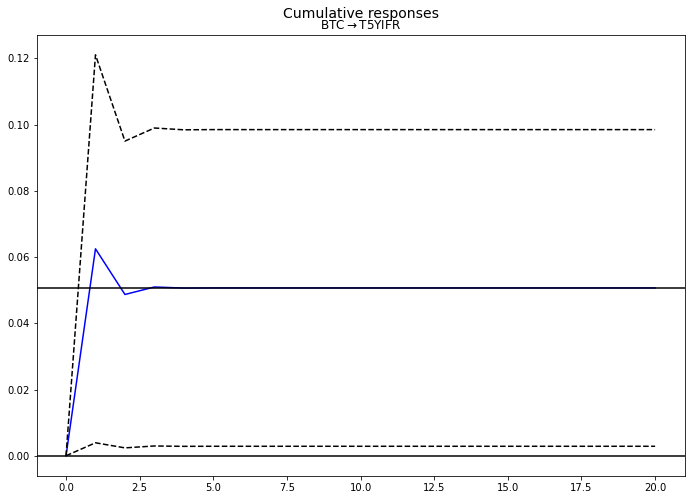

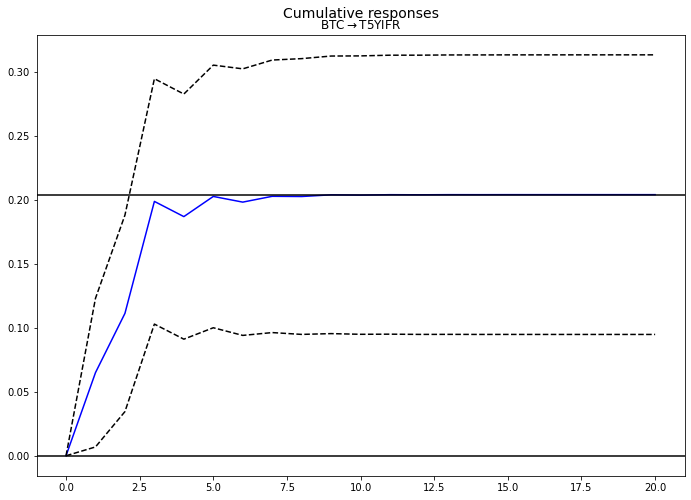

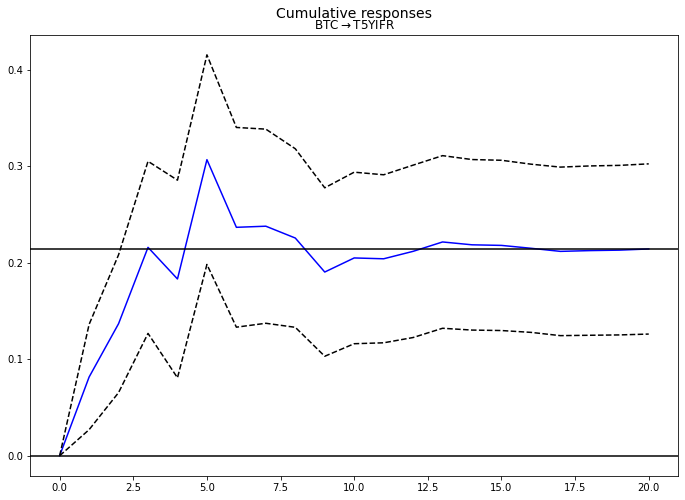

In [53]:


irf1 = VAR1.irf(20)
irf1 = irf1.plot_cum_effects(orth=False, impulse = "BTC", response = "T5YIFR", figsize = (10,7))

irf3 = VAR3.irf(20)
irf3 = irf3.plot_cum_effects(orth=False, impulse = "BTC", response = "T5YIFR", figsize = (10,7))

irf5 = VAR5.irf(20)
irf5 = irf5.plot_cum_effects(orth=False, impulse = "BTC", response = "T5YIFR", figsize = (10,7))

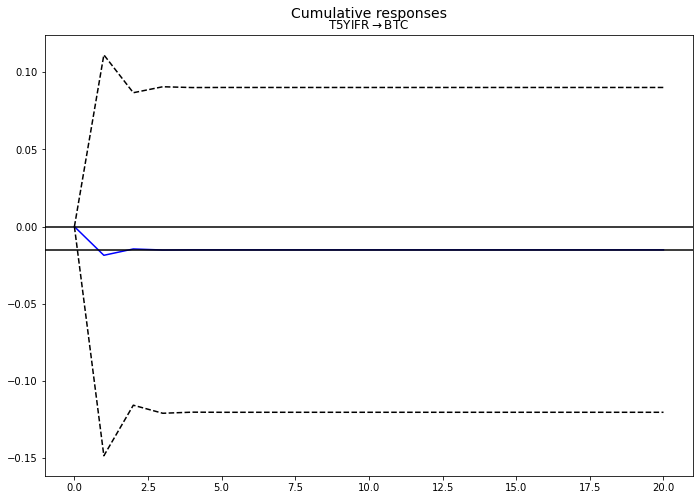

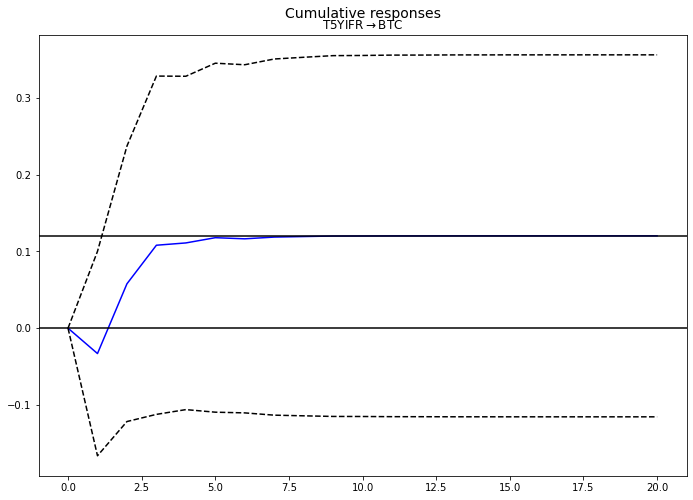

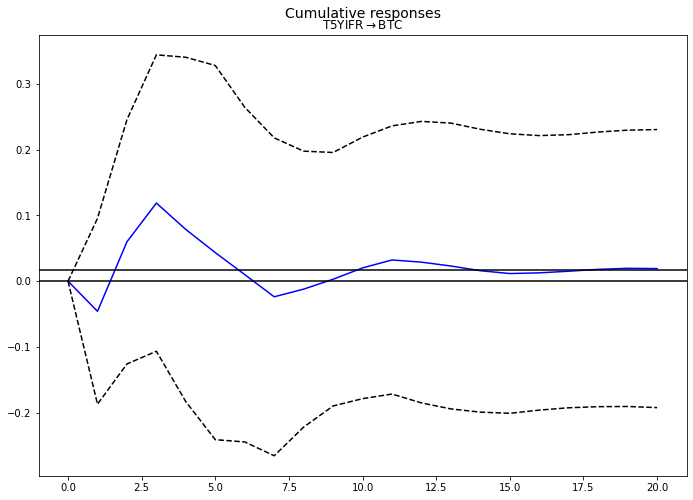

In [55]:
#estimating Impulse Response Functions of BTC to exogenous T5YIFR shock and printing accumulated effect for VAR 1,3 and 5.


irf1 = VAR1.irf(20)
irf1 = irf1.plot_cum_effects(orth=False, impulse = "T5YIFR", response = "BTC", figsize = (10,7))

irf3 = VAR3.irf(20)
irf3 = irf3.plot_cum_effects(orth=False, impulse = "T5YIFR", response = "BTC", figsize = (10,7))

irf5 = VAR5.irf(20)
irf5 = irf5.plot_cum_effects(orth=False, impulse = "T5YIFR", response = "BTC", figsize = (10,7))

Figure(720x504)


/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py:4075: UserWarning: Parsing '24-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  indexer = self.slice_indexer(start, stop, step)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py:6393: UserWarning: Parsing '24-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


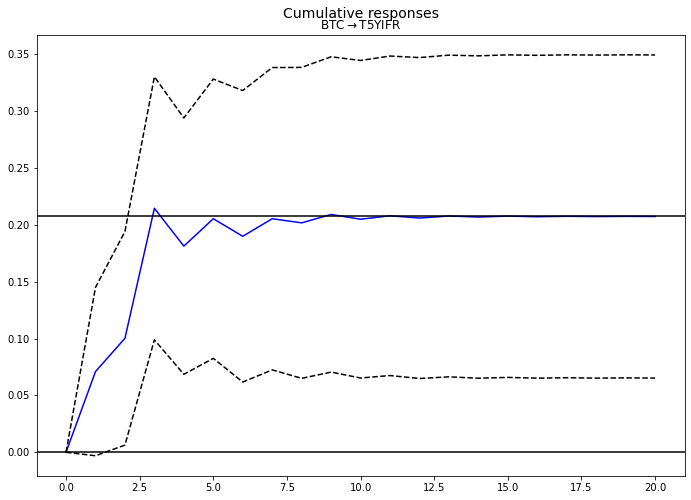

In [50]:
#Segmented IRF for pre-pandemic time period before CARES-Act


pre_cov19 = VAR(pct_values["01-01-2019":"24-03-2020"])                                                #Include relevant time-frame
VAR3_pre = pre_cov19.fit(maxlags = 3)                                                                 # estimate new VAR(3)

irf_pre = VAR3_pre.irf(20)                                                                            #Estimate VAR
print(irf_pre.plot_cum_effects(orth=False, impulse = "BTC", response = "T5YIFR", figsize = (10,7)))   # Plot cumulative IRF

Figure(720x504)


/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py:6393: UserWarning: Parsing '24-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


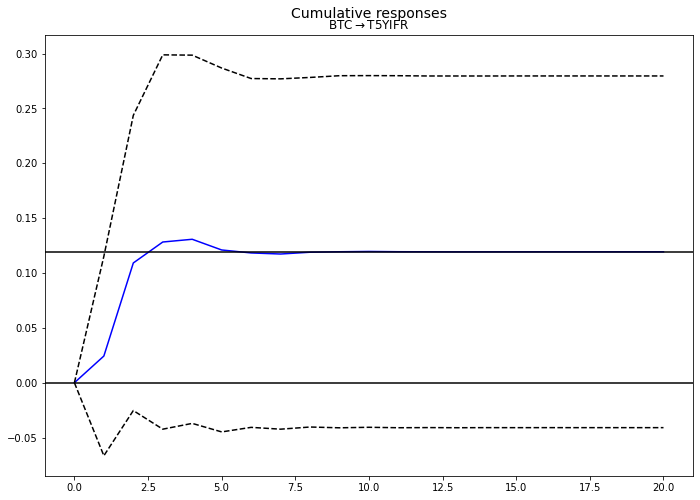

In [52]:
#Segmented IRF for pandemic time period after CARES-Act

post_cov19 = VAR(pct_values["24-03-2020":])                                                             # Include relevant time-frame
VAR3_post = post_cov19.fit(maxlags = 3)                                                                 # estimate new VAR(3)

irf_post = VAR3_post.irf(20)                                                                            # Estimate VAR
print(irf_post.plot_cum_effects(orth=False, impulse = "BTC", response = "T5YIFR", figsize = (10,7)))    # Plot cumulative IRF
